# Entropy-Based Image Classification
Entropy can be used as a feature in most of our machine learning applications. For this notebook, we will try to extract the entropy of an image to classify damage vs undamaged satellite images.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load and Preprocess the Images
First, we load satellite images from the `damaged` and `undamaged` folders and convert them into grayscale to simplify the pixel information focusing mainly on intensity variations relevant to entropy analysis.

In [2]:
def load_and_convert_to_grayscale(directory_path):
    """
    Load images from a directory and convert them to grayscale.
    
    Parameters:
        directory_path (str): Path to the directory containing images.
    
    Returns:
        list: A list of grayscale images.
    """
    grayscale_images = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                grayscale_images.append(image)
    return grayscale_images

def visualize_images(images, title, num_samples=5):
    """
    Visualize a few sample images.
    
    Parameters:
        images (list): List of images to visualize.
        title (str): Title for the visualization.
        num_samples (int): Number of images to display.
    """
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

def prepare_images_and_labels(damaged_images, undamaged_images):
    """
    Convert images to NumPy arrays, assign class labels, and combine them.

    Parameters:
        damaged_images (list): List of grayscale damaged images.
        undamaged_images (list): List of grayscale undamaged images.

    Returns:
        tuple: Combined images and labels as NumPy arrays.
    """
    damaged_images = np.array(damaged_images)
    undamaged_images = np.array(undamaged_images)

    damaged_labels = np.ones(len(damaged_images))  # Class label 1 for damaged
    undamaged_labels = np.zeros(len(undamaged_images))  # Class label 0 for undamaged

    images = np.concatenate((damaged_images, undamaged_images), axis=0)
    labels = np.concatenate((damaged_labels, undamaged_labels), axis=0)

    print(f"Total images: {len(images)}")
    print(f"Total labels: {len(labels)}")

    return images, labels

Loaded 60 damaged images.
Loaded 60 undamaged images.


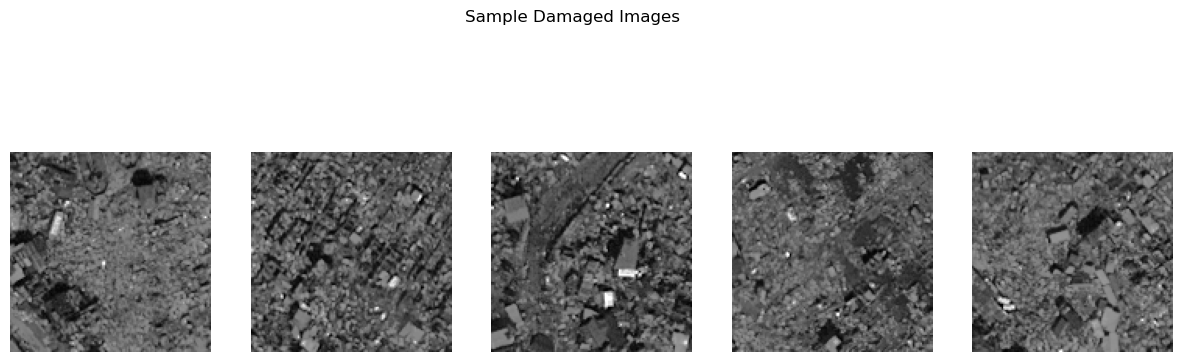

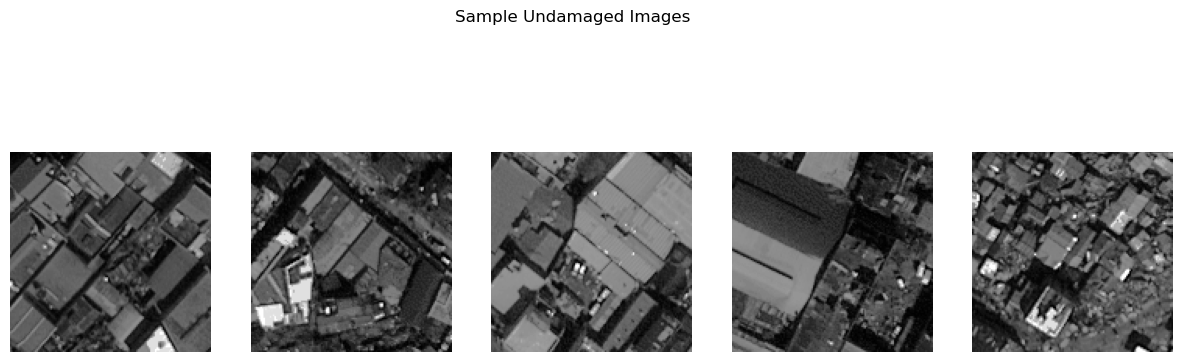

Total images: 120
Total labels: 120


In [3]:
damaged_images = load_and_convert_to_grayscale('damaged')
undamaged_images = load_and_convert_to_grayscale('undamaged')

print(f"Loaded {len(damaged_images)} damaged images.")
print(f"Loaded {len(undamaged_images)} undamaged images.")

visualize_images(damaged_images, "Sample Damaged Images")
visualize_images(undamaged_images, "Sample Undamaged Images")

images, labels = prepare_images_and_labels(damaged_images, undamaged_images)

# 2-3. Apply the Shannon Entropy Formula and Experiment Different Parameters
In this step, we quantify the texture complexity of each image by applying Shannon entropy, a statistical measure of randomness that effectively captures disorder within image patterns.

**Whole-image entropy** is computed as a baseline to understand overall complexity then we use multiple **sliding windows sizes** to calculate entropy within localized regions of the image. 3 types of entropy-based features are extracted per image: **mean, maximum and variance** of localized entropy values to assess how entropy distributions shift across images and between classes.

In [4]:
def compute_entropy_windows(image, window_size=16):
    windows = view_as_windows(image, (window_size, window_size), step=window_size)
    entropy_values = [shannon_entropy(win) for row in windows for win in row]
    mean_entropy = np.mean(entropy_values)
    max_entropy = np.max(entropy_values)
    var_entropy = np.var(entropy_values)
    return mean_entropy, max_entropy, var_entropy

def experiment_entropy_features(images, window_sizes=[8, 16, 32]):
    """
    Experiment with different parameters for entropy computation.

    Parameters:
        images (list): List of grayscale images.
        window_sizes (list): List of window sizes to experiment with (e.g., [8, 16, 32]).
        thresholds (list): List of thresholds for binning grayscale values (e.g., [50, 100, 150]).

    Returns:
        dict: Dictionary containing entropy features for each parameter combination.
    """
    results = {}

    for window_size in window_sizes:
        results[window_size] = {"mean_entropies": [], "max_entropies": [], "var_entropies": []}

        for img in images:
            mean_entropy, max_entropy, var_entropy = compute_entropy_windows(img, window_size=window_size)
            results[window_size]["mean_entropies"].append(mean_entropy)
            results[window_size]["max_entropies"].append(max_entropy)
            results[window_size]["var_entropies"].append(var_entropy)
    
    return results

def visualize_entropy_side_by_side(results):
    """
    Visualize mean and max entropy side by side for different window sizes.

    Parameters:
        results (dict): Dictionary containing entropy features for each window size.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    for window_size in results:
        mean_entropies = results[window_size]["mean_entropies"]
        axes[0].plot(mean_entropies, label=f"Window Size {window_size}", marker='o')
    axes[0].set_title("Mean Entropy")
    axes[0].set_xlabel("Image Index")
    axes[0].set_ylabel("Entropy")
    axes[0].legend()
    axes[0].grid(True)

    for window_size in results:
        max_entropies = results[window_size]["max_entropies"]
        axes[1].plot(max_entropies, label=f"Window Size {window_size}", marker='x')
    axes[1].set_title("Max Entropy")
    axes[1].set_xlabel("Image Index")
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle("Localized Entropy with Different Window Sizes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

def visualize_var_entropy(results):
    """
    Visualize variance entropy for different window sizes in a separate figure.

    Parameters:
        results (dict): Dictionary containing entropy features for each window size.
    """
    plt.figure(figsize=(10, 6))

    for window_size in results:
        var_entropies = results[window_size]["var_entropies"]
        plt.plot(var_entropies, label=f"Window Size {window_size}", marker='s')

    plt.title("Variance Entropy for Different Window Sizes")
    plt.xlabel("Image Index")
    plt.ylabel("Variance Entropy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_entropy_distribution(entropies, labels, feature_name="Whole Image Entropy"):
    """
    Visualize the distribution of entropy values for damaged and undamaged images.

    Parameters:
        entropies (list): List of entropy values (e.g., mean, max, or variance).
        labels (list): List of corresponding labels (1 for damaged, 0 for undamaged).
        feature_name (str): Name of the entropy feature being visualized.
    """
    damaged_entropies = [entropies[i] for i in range(len(labels)) if labels[i] == 1]
    undamaged_entropies = [entropies[i] for i in range(len(labels)) if labels[i] == 0]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].boxplot([damaged_entropies, undamaged_entropies], labels=["Damaged", "Undamaged"])
    axes[0].set_title(f"{feature_name} Distribution (Box Plot)")
    axes[0].set_ylabel("Entropy")

    axes[1].hist(damaged_entropies, bins=20, alpha=0.7, label="Damaged", color="red")
    axes[1].hist(undamaged_entropies, bins=20, alpha=0.7, label="Undamaged", color="blue")
    axes[1].axvline(np.mean(damaged_entropies), color='red', linestyle='dashed')
    axes[1].axvline(np.mean(undamaged_entropies), color='blue', linestyle='dashed')
    axes[1].set_title(f"{feature_name} Distribution (Histogram)")
    axes[1].set_xlabel("Entropy")
    axes[1].set_ylabel("Frequency")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

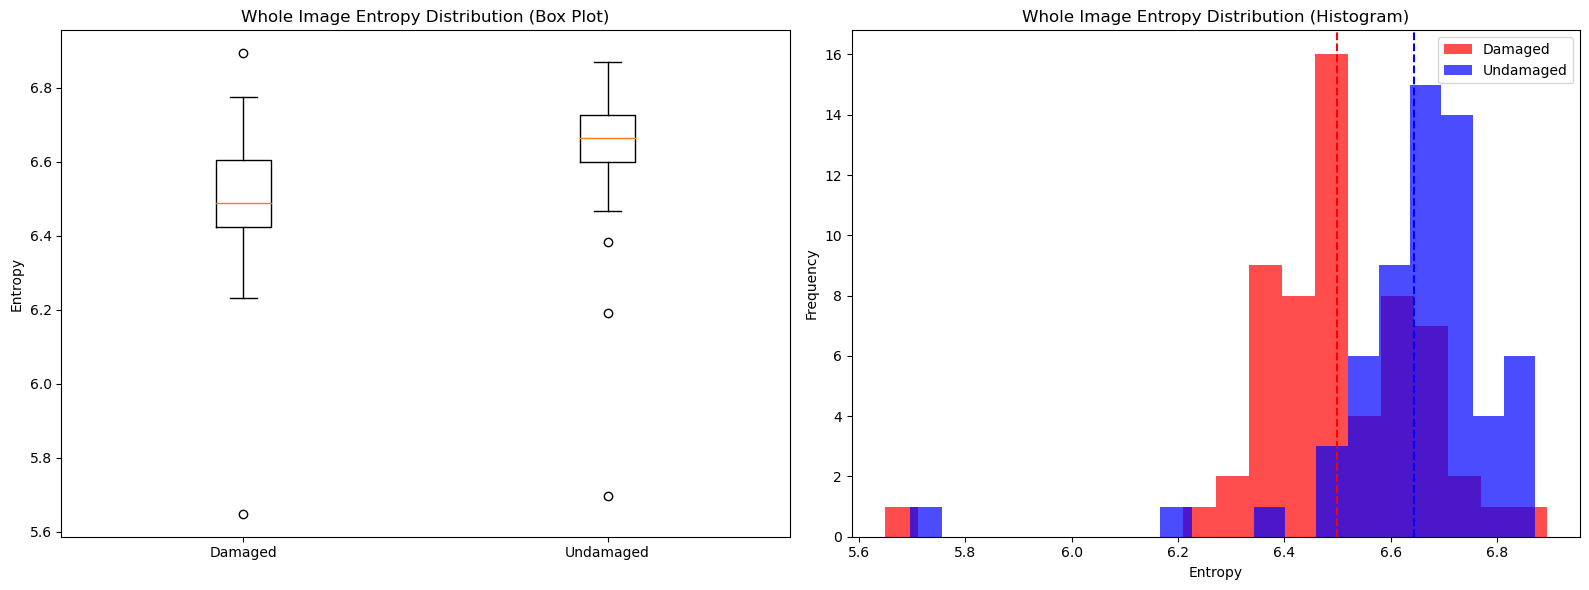

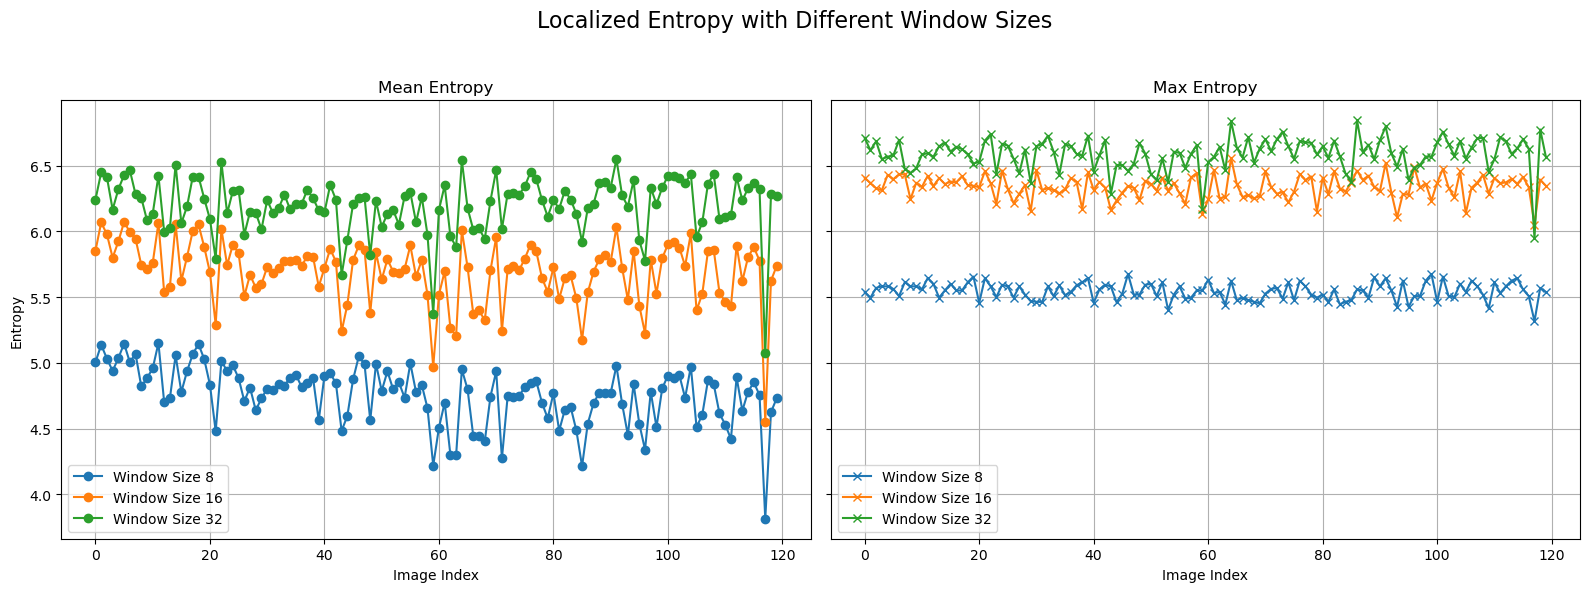

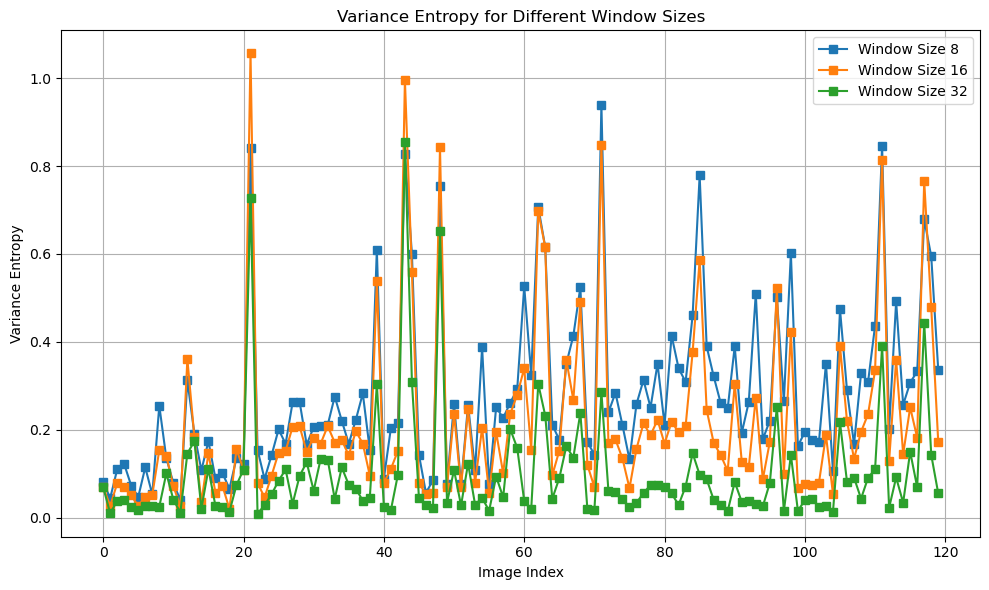

In [5]:
window_sizes = [8, 16, 32]

# Whole image shannon entropy
whole_image_entropies = [shannon_entropy(img) for img in images]
visualize_entropy_distribution(whole_image_entropies, labels)

# Localized shannon entropy
results = experiment_entropy_features(images, window_sizes=window_sizes)
visualize_entropy_side_by_side(results)
visualize_var_entropy(results)

In [6]:
def prepare_feature_matrix(results, labels):
    """
    Prepare the feature matrix and labels for training.

    Parameters:
        results (dict): Dictionary containing entropy features for each window size.
        labels (list): List of labels (1 for damaged, 0 for undamaged).

    Returns:
        pd.DataFrame: DataFrame containing features for all window sizes and labels.
    """
    features = []

    for i in range(len(labels)):
        row = []

        for window_size in [8, 16, 32]:
            mean_entropies = results[window_size]["mean_entropies"]
            max_entropies = results[window_size]["max_entropies"]
            var_entropies = results[window_size]["var_entropies"]
            row.extend([mean_entropies[i], max_entropies[i], var_entropies[i]])

        row.append(labels[i])
        features.append(row)

    columns = [
        "mean_entropy_8", "max_entropy_8", "variance_entropy_8",
        "mean_entropy_16", "max_entropy_16", "variance_entropy_16",
        "mean_entropy_32", "max_entropy_32", "variance_entropy_32",
        "label"
    ]

    df = pd.DataFrame(features, columns=columns)
    return df

def check_class_balance(y_train):
    """
    Check the balance of classes in the training labels.

    Parameters:
        y_train (list): List of training labels.

    Returns:
        dict: Dictionary with class counts.
    """
    unique, counts = np.unique(y_train, return_counts=True)
    class_balance = dict(zip(unique, counts))
    return class_balance

In [7]:
df = prepare_feature_matrix(results, labels)

X = df.drop(columns=["label"]).values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

class_balance = check_class_balance(y_train)
print("Class balance in training set:", class_balance)

df.head()

X_train shape: (96, 9)
X_test shape: (24, 9)
y_train shape: (96,)
y_test shape: (24,)
Class balance in training set: {0.0: 49, 1.0: 47}


,mean_entropy_8,max_entropy_8,variance_entropy_8,mean_entropy_16,max_entropy_16,variance_entropy_16,mean_entropy_32,max_entropy_32,variance_entropy_32,label
0,5.004079,5.538910,0.081761,5.852580,6.407936,0.070650,6.241995,6.710982,0.069596,1.0
1,5.137068,5.495865,0.044245,6.068289,6.368721,0.026456,6.449477,6.617518,0.010072,1.0
2,5.031952,5.570160,0.109817,5.978339,6.327490,0.078108,6.413258,6.686322,0.038020,1.0
3,4.938438,5.581955,0.121750,5.799962,6.313869,0.069317,6.166171,6.549949,0.039242,1.0
4,5.035609,5.581955,0.072805,5.923502,6.429685,0.050463,6.321021,6.569176,0.023235,1.0


# 4. Train a Classifier
With the extracted entropy features, we evaluate the predictive power of these features by training multiple classifiers. This allows us to assess whether entropy statistics alone contain enough discriminatory information to distinguish damaged from undamaged satellite images.

In [8]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logistic, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM:")
print(classification_report(y_test, y_pred_svm, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.83      0.45      0.59        11
         1.0       0.67      0.92      0.77        13

    accuracy                           0.71        24
   macro avg       0.75      0.69      0.68        24
weighted avg       0.74      0.71      0.69        24

Confusion Matrix:
 [[ 5  6]
 [ 1 12]]

SVM:
              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63        11
         1.0       1.00      0.00      0.00        13

    accuracy                           0.46        24
   macro avg       0.73      0.50      0.31        24
weighted avg       0.75      0.46      0.29        24

Confusion Matrix:
 [[11  0]
 [13  0]]

Random Forest:
              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80        11
         1.0       0.80      0.92      0.86        13

    accuracy                           0.83        24
   macro 

# 5. Evaluate the Model
Based on the results, Random Forest is the best model which outperformed other models and captured the signal encoded in entropy-based features.

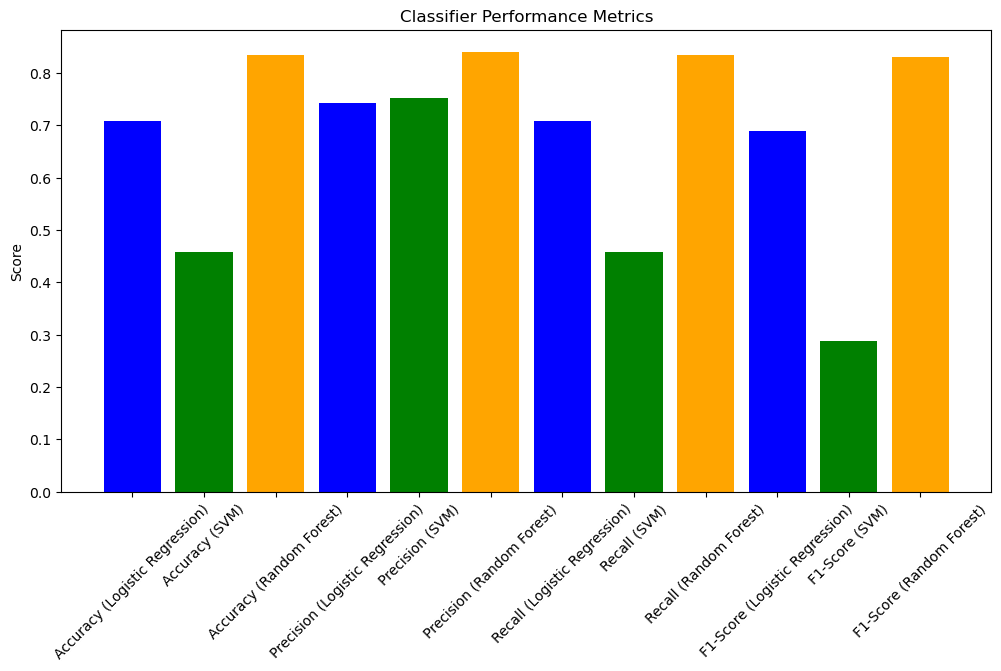

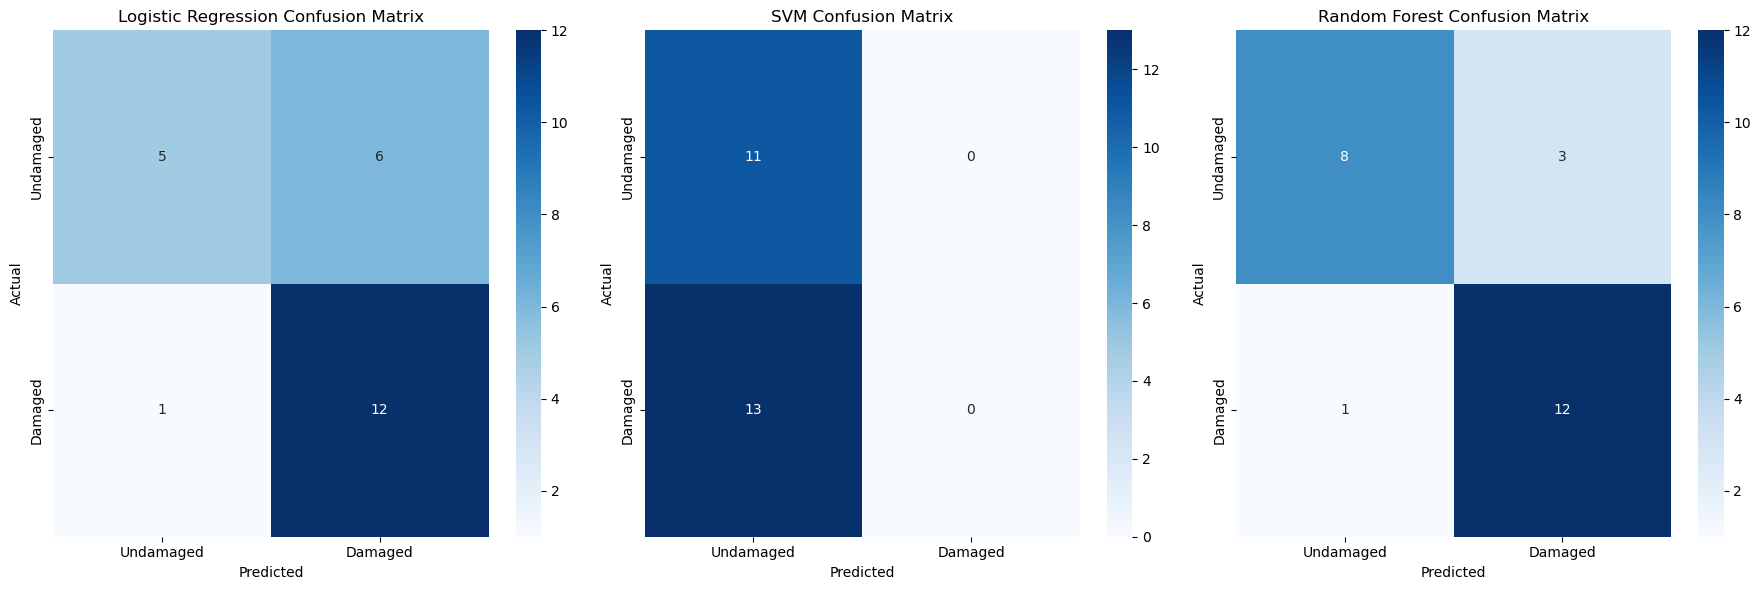

In [9]:
models = {
    "Logistic Regression": logistic_model,
    "SVM": svm_model,
    "Random Forest": rf_model
}

accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    cm = confusion_matrix(y_test, y_pred)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(report["weighted avg"]["precision"])
    recalls.append(report["weighted avg"]["recall"])
    f1_scores.append(report["weighted avg"]["f1-score"])
    confusion_matrices.append(cm)

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracies, precisions, recalls, f1_scores]

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar([f"{metric} ({model})" for model in models.keys()], values[i], color=["blue", "green", "orange"])
plt.title("Classifier Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(18, 6))
for i, (model_name, cm) in enumerate(zip(models.keys(), confusion_matrices)):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Undamaged", "Damaged"], yticklabels=["Undamaged", "Damaged"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Questions

**Question 1: Which entropy features (e.g., mean entropy, max entropy) were most useful for classification?**

After training a Random Forest classifier using various entropy features, **mean and variance entropy** was the most useful feature for classifying damaged and undamaged images considering the feature importance score. This is also further supported by the box plots which showed a bit of separation between classes relative to the max entropy feature.

The reason for this is because `mean_entropy` captures the overall texture complexity which smooths out noise and highlights whether an image is globally more structured or chaotic. While, `max_entropy` captures the single most chaotic region in the image which leads to limited perspective as this does not represent overall structure and prone to false signals. Additionally, `variance_entropy` may be a good predictor as undamaged images tend to have higher variance likely because they contain a mix of highly structured regions, while damaged images often become uniformly chaotic.

Hence, mean and variance entropy provide a more holistic and stable representation of an image’s texture, helping distinguish damage-related irregularities across the entire frame. In contrast, max entropy focuses narrowly on an extreme value, which fails to generalize class patterns and thus contributes less to classification performance.



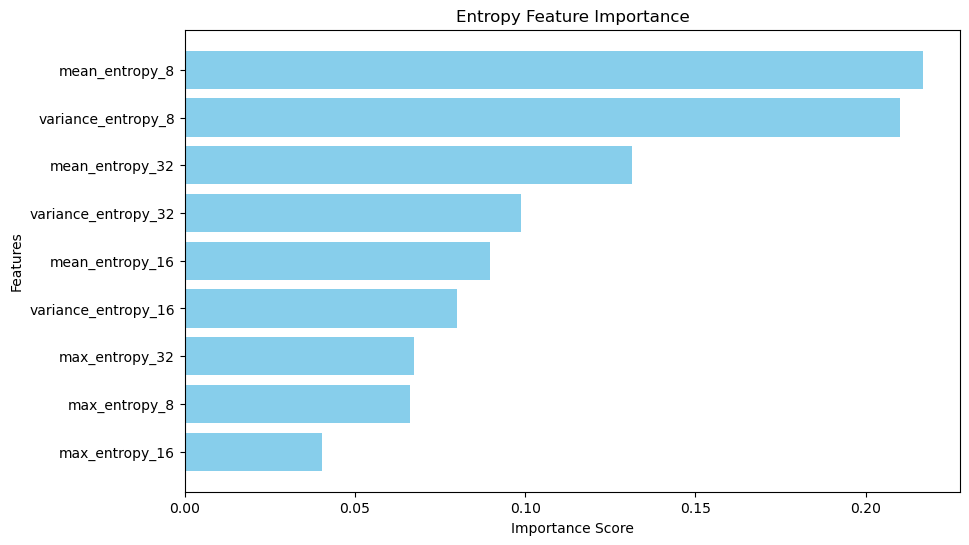

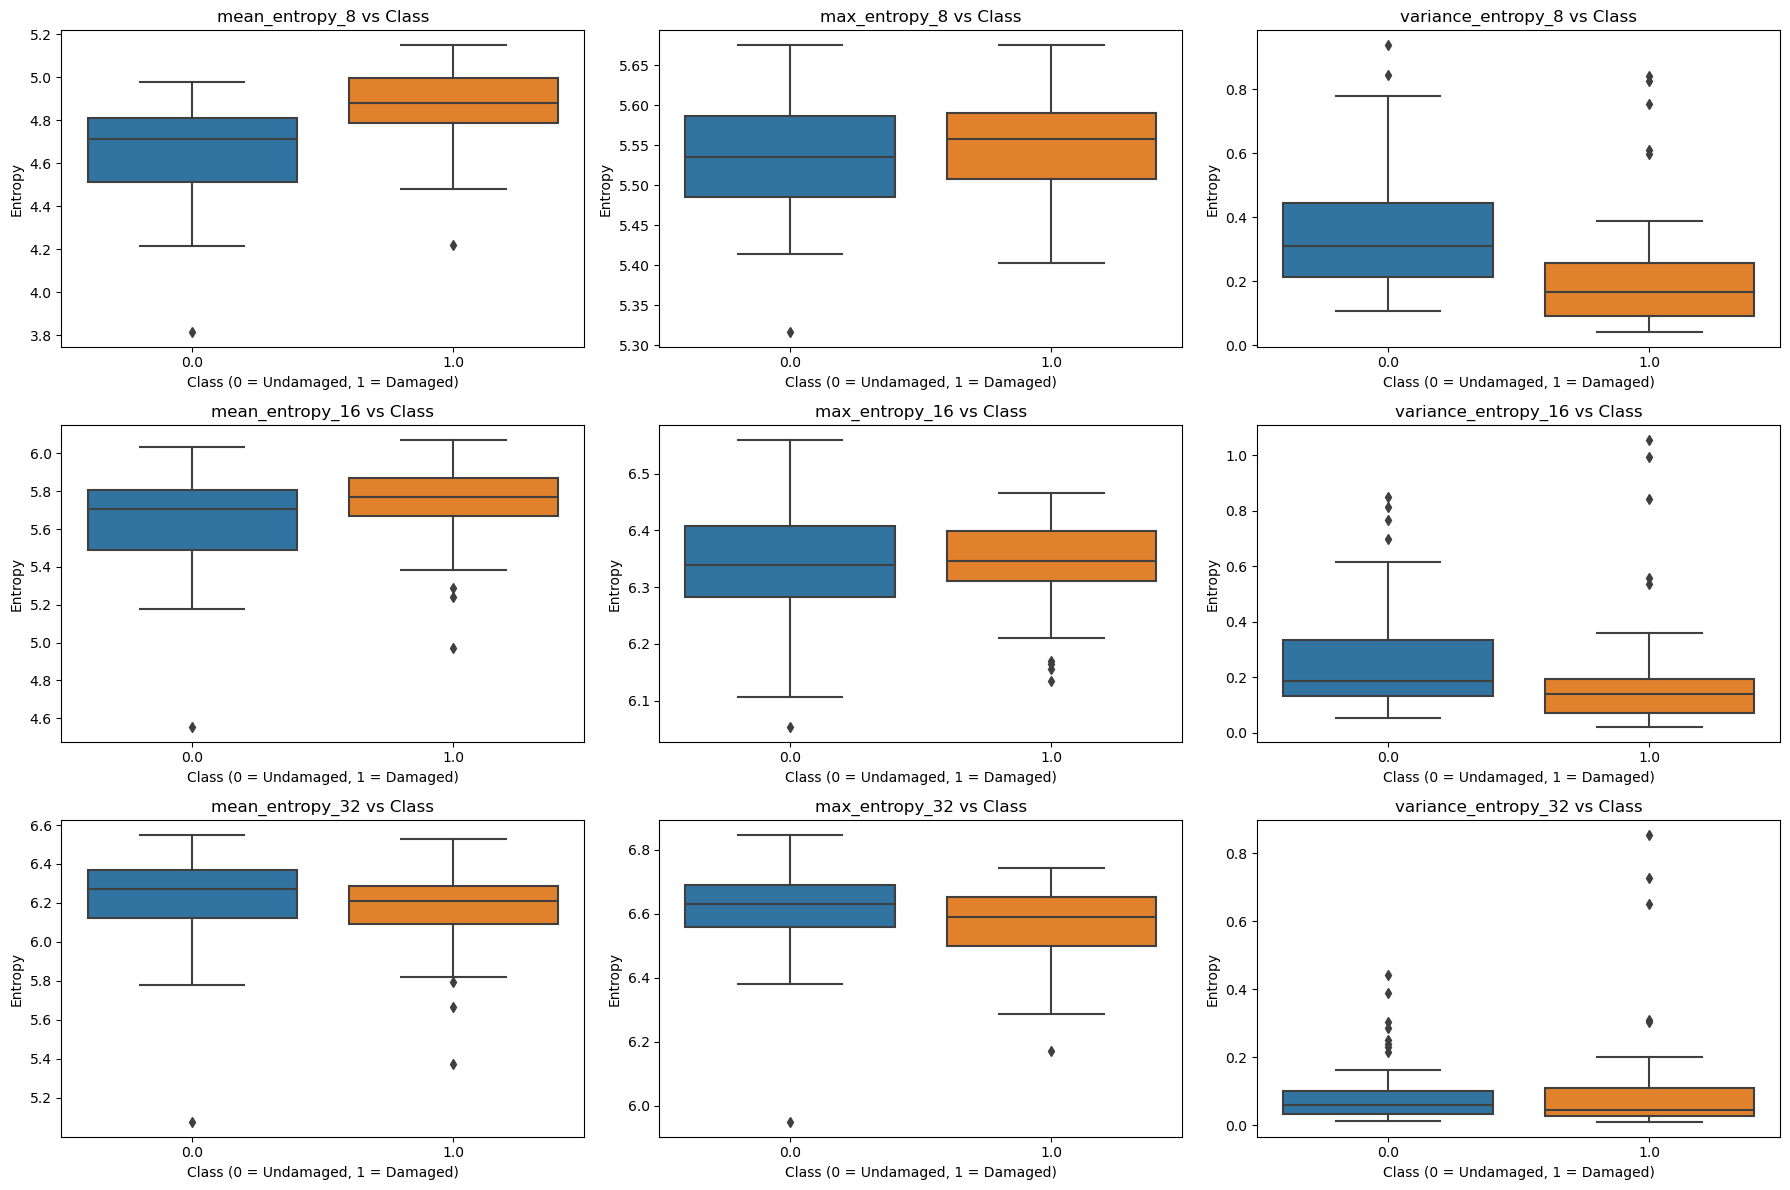

In [10]:
X = df.drop(columns=["label"])
y = df["label"]

importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.title("Entropy Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(18, 12))
for i, feature in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df, x="label", y=feature)
    plt.title(f"{feature} vs Class")
    plt.xlabel("Class (0 = Undamaged, 1 = Damaged)")
    plt.ylabel("Entropy")
plt.tight_layout()
plt.show()

**Question 2: How does changing the window size affect your classifier’s performance?**

The performance of the Random Forest model varies noticeably with respect to the different window sizes, with smaller windows (8x8) achieving the highest accuracy. This indicates that window size directly influences the level of detail captured in the entropy features.

Smaller windows capture fine-grained local variations, which are useful for detecting spatially **localized damage patterns** that might be averaged out in larger regions. On the other hand, larger windows may be better at characterizing **global damage patterns** when subtle texture differences are not sufficient. Hence, this highlights that choosing the appropriate window size is important for different problems, as it affects the predictive performance of the models.


Evaluating for Window Size: 8x8
Accuracy for Window Size 8: 0.7083

Evaluating for Window Size: 16x16
Accuracy for Window Size 16: 0.5000

Evaluating for Window Size: 32x32
Accuracy for Window Size 32: 0.5833


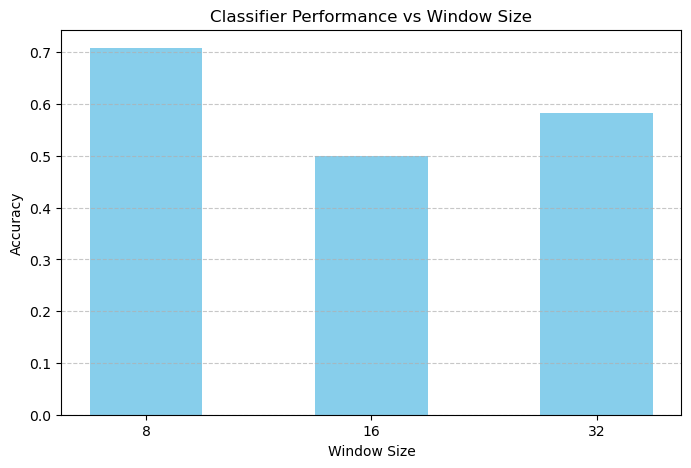

In [11]:
def evaluate_window_sizes(results, labels, window_sizes=[8, 16, 32]):
    """
    Evaluate classifier performance for different window sizes.

    Parameters:
        results (dict): Dictionary containing entropy features for each window size.
        labels (list): List of labels (1 for damaged, 0 for undamaged).
        window_sizes (list): List of window sizes to evaluate.

    Returns:
        dict: Dictionary containing accuracy scores for each window size.
    """
    performance = {}

    for window_size in window_sizes:
        print(f"\nEvaluating for Window Size: {window_size}x{window_size}")

        df = pd.DataFrame({
            f"mean_entropy_{window_size}": results[window_size]["mean_entropies"],
            f"max_entropy_{window_size}": results[window_size]["max_entropies"],
            f"variance_entropy_{window_size}": results[window_size]["var_entropies"],
            "label": labels
        })

        X = df.drop(columns=["label"]).values
        y = df["label"].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        performance[window_size] = accuracy
        print(f"Accuracy for Window Size {window_size}: {accuracy:.4f}")

    return performance

performance = evaluate_window_sizes(results, labels)
plt.figure(figsize=(8, 5))
plt.bar(range(len(performance)), performance.values(), color="skyblue", width=0.5)
plt.title("Classifier Performance vs Window Size")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(len(performance)), labels=performance.keys())
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**Question 3: Did thresholding or binning the grayscale values help or hurt entropy-based differentiation?**

Based on the accuracy from the different methods shown below, it reflects that binning the grayscale values helped increase the performance of entropy-based classification, while thresholding had slightly positive effects up to a certain threshold. Binning with 8 intensity levels achieved the highest accuracy, while thresholding at 50 and 100 resulted to slightly improved performance, however thresholding at 150 led to a noticeable drop in accuracy.

The reason for this can be explained by how these methods affect the distribution of pixel intensities, which influences shannon entropy calculations. Binning reduces the number of gray levels, which simplifies the image but preserves variation across regions. This leads the entropy patterns to be more robust and easier to differentiate between different class textures. On the other hand, thresholding is a more aggressive transformation that forces the pixels into binary states based on a certain threshold, which can erase subtle texture differences when it is set too high, leading to reduced classifier performance.

Hence, binning helped by enhancing the contrast of meaningful patterns while reducing noise, making it easier for entropy to capture structural complexity. Thresholding offered minor gains at best, and could hurt when it over-simplified the image. 


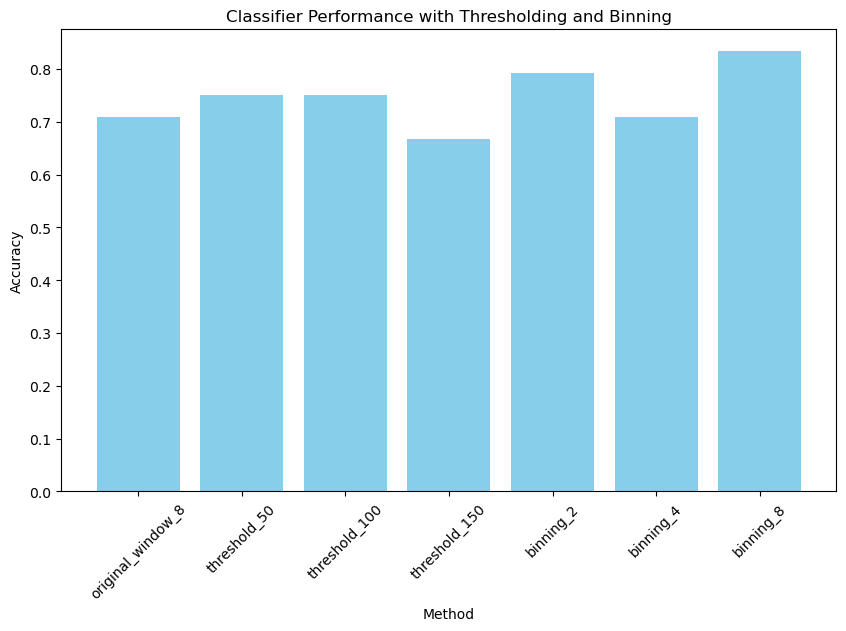

In [12]:
def apply_threshold(image, threshold):
    """
    Apply binary thresholding to a grayscale image.

    Parameters:
        image (numpy.ndarray): Grayscale image.
        threshold (int): Threshold value (0-255).

    Returns:
        numpy.ndarray: Thresholded binary image.
    """
    return np.where(image > threshold, 255, 0)

def apply_binning(image, num_bins):
    """
    Apply intensity binning to a grayscale image.

    Parameters:
        image (numpy.ndarray): Grayscale image.
        num_bins (int): Number of bins to reduce intensity levels.

    Returns:
        numpy.ndarray: Binned image.
    """
    max_intensity = 255
    bin_size = max_intensity // num_bins
    binned_image = (image // bin_size) * bin_size
    return binned_image

def experiment_with_thresholding_and_binning(images, labels, thresholds=[50, 100, 150], num_bins=[2, 4, 8], window_size=8):
    """
    Experiment with thresholding and binning on entropy computation.

    Parameters:
        images (list): List of grayscale images.
        labels (list): List of labels (1 for damaged, 0 for undamaged).
        thresholds (list): List of thresholds for binary thresholding.
        num_bins (list): List of binning levels for intensity reduction.
        window_size (int): Window size for entropy computation.

    Returns:
        dict: Dictionary containing accuracy scores for each method.
    """
    performance = {}

    original_results = experiment_entropy_features(images, window_sizes=[window_size])
    performance["original_window_8"] = evaluate_entropy_features(original_results, labels, window_size)

    for threshold in thresholds:
        thresholded_images = [apply_threshold(img, threshold) for img in images]
        thresholded_results = experiment_entropy_features(thresholded_images, window_sizes=[window_size])
        performance[f"threshold_{threshold}"] = evaluate_entropy_features(thresholded_results, labels, window_size)

    for bins in num_bins:
        binned_images = [apply_binning(img, bins) for img in images]
        binned_results = experiment_entropy_features(binned_images, window_sizes=[window_size])
        performance[f"binning_{bins}"] = evaluate_entropy_features(binned_results, labels, window_size)

    return performance

def evaluate_entropy_features(results, labels, window_size):
    """
    Train and evaluate a classifier using entropy features.

    Parameters:
        results (dict): Dictionary containing entropy features.
        labels (list): List of labels (1 for damaged, 0 for undamaged).
        window_size (int): Window size for entropy computation.

    Returns:
        float: Accuracy score of the classifier.
    """
    df = pd.DataFrame({
        f"mean_entropy_{window_size}": results[window_size]["mean_entropies"],
        f"max_entropy_{window_size}": results[window_size]["max_entropies"],
        f"variance_entropy_{window_size}": results[window_size]["var_entropies"],
        "label": labels
    })

    X = df.drop(columns=["label"]).values
    y = df["label"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

performance = experiment_with_thresholding_and_binning(images, labels)
plt.figure(figsize=(10, 6))
methods = list(performance.keys())
accuracies = list(performance.values())
plt.bar(methods, accuracies, color="skyblue")
plt.title("Classifier Performance with Thresholding and Binning")
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

**Question 4: Is there a noticeable difference in entropy distribution between damaged and undamaged images?**

Based on the results below, we can see that there is a subtle difference in entropy distribution particularly for mean and variance entropy with a window size of 8. Damaged images exhibit a shift toward higher mean entropy values, indicating greater overall texture complexity. While undamaged images are slightly leaning towards the left which highlights that it is more predictable. Moreover, the variance entropy features indicates that undamaged images tend to have higher entropy variance, while damaged images cluster around lower variance values. This suggests that damaged images have more uniformly chaotic textures, while undamaged images contain a mixture of structured and smooth regions, leading to higher variance in localized entropy.

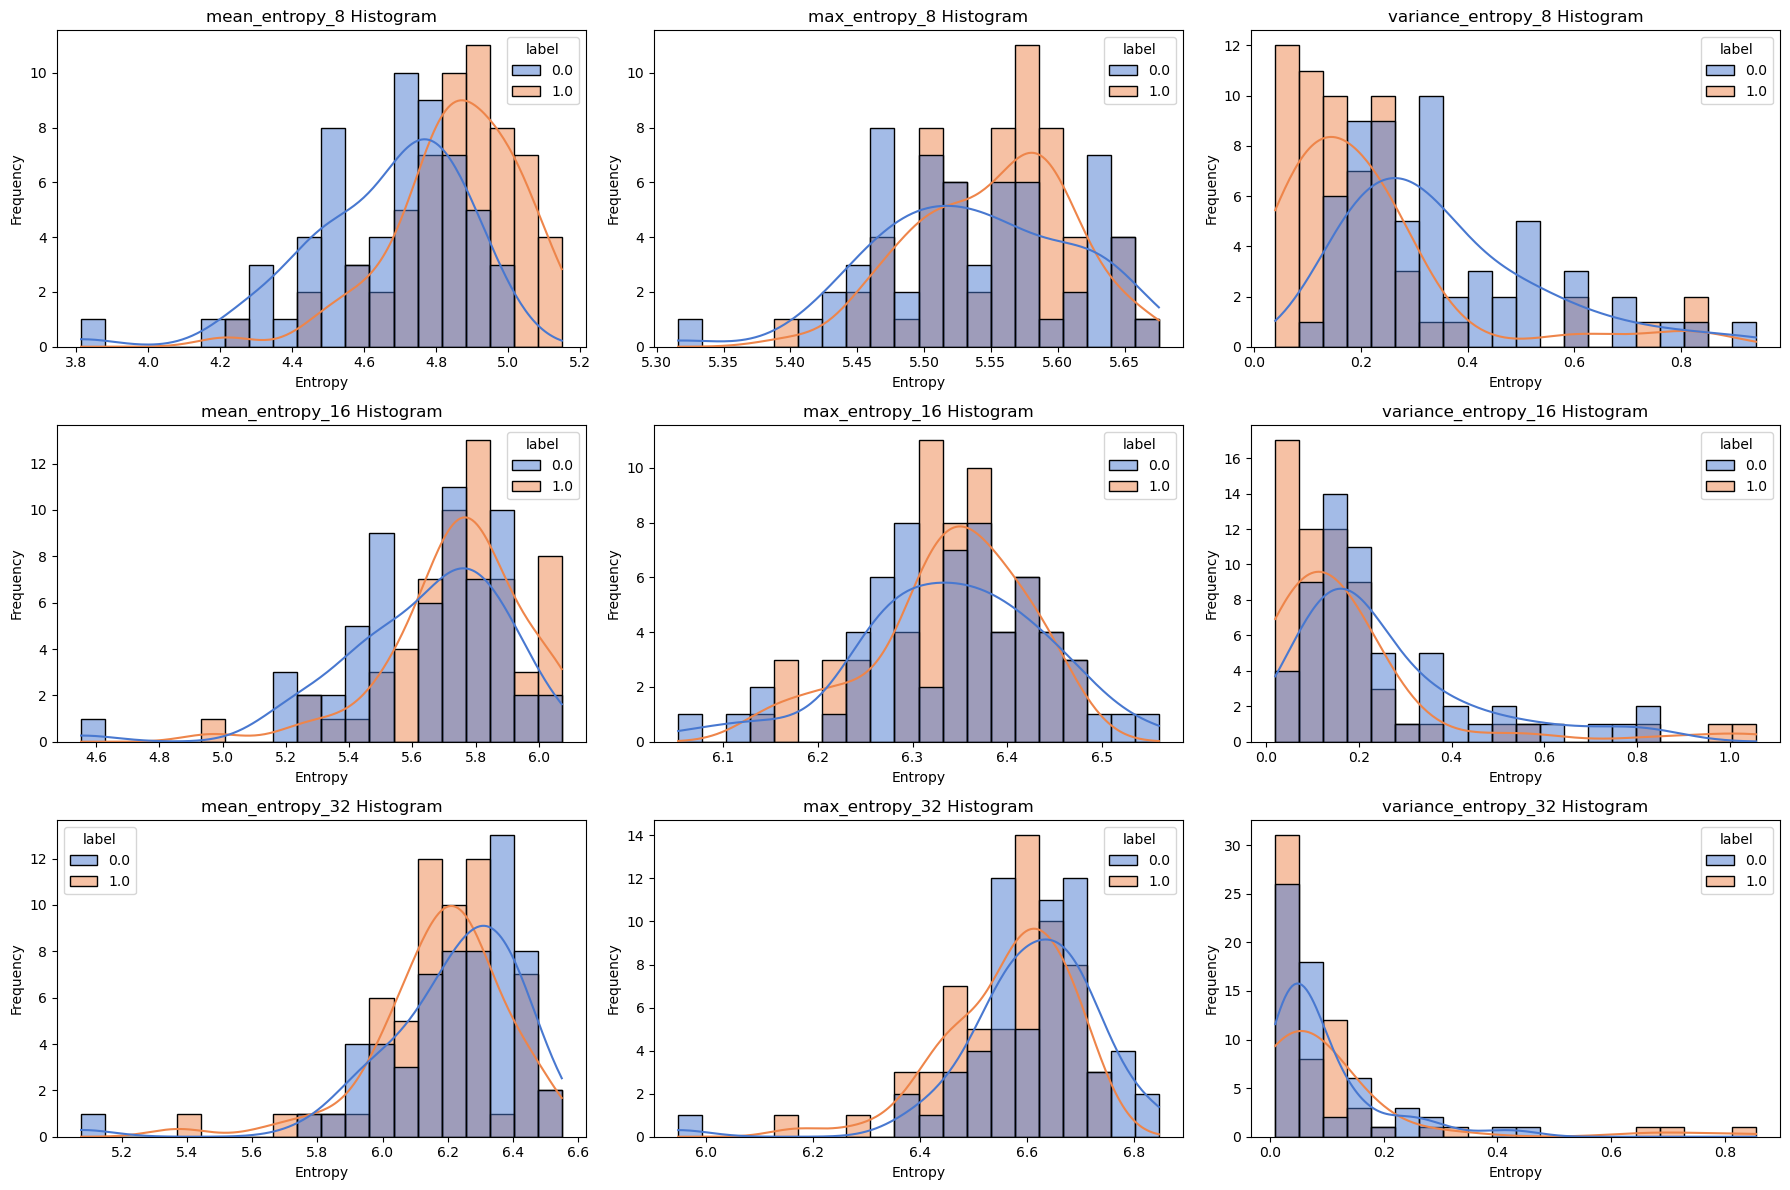

In [13]:
def visualize_entropy_histograms(df, features, label_column="label"):
    """
    Visualize the distribution of entropy features for damaged and undamaged images using histograms.

    Parameters:
        df (pd.DataFrame): DataFrame containing entropy features and labels.
        features (list): List of entropy feature column names to visualize.
        label_column (str): Name of the label column (default: "label").
    """
    plt.figure(figsize=(18, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        sns.histplot(data=df, x=feature, hue=label_column, kde=True, palette="muted", bins=20)
        plt.title(f"{feature} Histogram")
        plt.xlabel("Entropy")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

entropy_features = [
    "mean_entropy_8", "max_entropy_8", "variance_entropy_8",
    "mean_entropy_16", "max_entropy_16", "variance_entropy_16",
    "mean_entropy_32", "max_entropy_32", "variance_entropy_32"
]

df = prepare_feature_matrix(results, labels)
visualize_entropy_histograms(df, entropy_features)

**Question 5: How do you think can entropy-based classification compare to using raw pixel values or CNNs?**

**Compared to raw pixel values**, raw pixels are highly sensitive to lighting, scale and alignment while entropy on the other hand, summarizes local texture complexity making it more efficient and less prone to overfitting especially for small datasets.

**Compared to Convolutional Neural Networks (CNNs)**, these neural networks are robust because they learn multi-scale spatial patterns, edges, textures and high-level features automatically, often achieving high accuracy in image classification. However, these usually requires large amount of computational resources and longer training times, which can be a roadblock especially for smaller organizations that do not have the capacity to buy GPUs or TPUs. Whereas, entropy features can be extracted quickly and can be used with basic machine learning models which is ideal for low-resource or interpretability requirements.

This exercise highlights that entropy-based classification is a great alternative from raw pixel features and deep learning approaches such as CNN in classifying images. Entropy-based classification shows that it is computationally efficient and highly interpretable. The Shannon entropy values can be extracted easily just by computing the grayscale image values and features like mean, max and variance entropy provides clear insights into the texture and complexity of the images in which a basic machine learning model can effectively classify just by using these features.